In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
import tensorflowjs as tfjs
import os
import pickle
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print(tf.config.list_physical_devices('GPU'))

[]


In [32]:
# Constants
BATCH_SIZE = 64
LR = 1e-4

In [9]:
# Load training data
with open('data/matches/diamond.ds', 'rb') as f:
    training_data = pickle.load(f)

In [23]:
# Partition Dataset
train_len = int(training_data[0].shape[0] * 0.9)

train_x = training_data[0][:train_len]
train_y = training_data[1][:train_len]

test_x = training_data[0][train_len:]
test_y = training_data[1][train_len:]

In [28]:
def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim=170))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    return model

In [29]:
model = create_model()

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               43776     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 85,985
Trainable params: 85,985
Non-trainable params: 0
_________________________________________________________________


In [33]:
loss = losses.BinaryCrossentropy(from_logits=True)
optimizer = optimizers.Adam(learning_rate=LR)
model.compile(loss=loss, optimizer=optimizer, metrics=[tf.metrics.BinaryAccuracy()])

In [34]:
history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, validation_split=0.1, epochs=200)

Epoch 1/200
2069/2069 [==============================] - 3s 1ms/step - loss: 0.6933 - binary_accuracy: 0.4963 - val_loss: 0.6928 - val_binary_accuracy: 0.4912
Epoch 2/200
2069/2069 [==============================] - 2s 975us/step - loss: 0.6919 - binary_accuracy: 0.4963 - val_loss: 0.6925 - val_binary_accuracy: 0.4912
Epoch 3/200
2069/2069 [==============================] - 2s 965us/step - loss: 0.6911 - binary_accuracy: 0.4964 - val_loss: 0.6930 - val_binary_accuracy: 0.4912
Epoch 4/200
2069/2069 [==============================] - 2s 962us/step - loss: 0.6902 - binary_accuracy: 0.4966 - val_loss: 0.6931 - val_binary_accuracy: 0.4913
Epoch 5/200
2069/2069 [==============================] - 2s 975us/step - loss: 0.6888 - binary_accuracy: 0.4971 - val_loss: 0.6924 - val_binary_accuracy: 0.4914
Epoch 6/200
2069/2069 [==============================] - 2s 964us/step - loss: 0.6874 - binary_accuracy: 0.4985 - val_loss: 0.6933 - val_binary_accuracy: 0.4919
Epoch 7/200
2069/2069 [=============

Epoch 52/200
2069/2069 [==============================] - 2s 981us/step - loss: 0.4424 - binary_accuracy: 0.7727 - val_loss: 1.0561 - val_binary_accuracy: 0.5056
Epoch 53/200
2069/2069 [==============================] - 2s 980us/step - loss: 0.4367 - binary_accuracy: 0.7758 - val_loss: 1.0858 - val_binary_accuracy: 0.5088
Epoch 54/200
2069/2069 [==============================] - 2s 977us/step - loss: 0.4320 - binary_accuracy: 0.7800 - val_loss: 1.0888 - val_binary_accuracy: 0.5086
Epoch 55/200
2069/2069 [==============================] - 2s 985us/step - loss: 0.4272 - binary_accuracy: 0.7824 - val_loss: 1.0907 - val_binary_accuracy: 0.5107
Epoch 56/200
2069/2069 [==============================] - 2s 984us/step - loss: 0.4231 - binary_accuracy: 0.7855 - val_loss: 1.1121 - val_binary_accuracy: 0.5111
Epoch 57/200
2069/2069 [==============================] - 2s 981us/step - loss: 0.4179 - binary_accuracy: 0.7896 - val_loss: 1.1465 - val_binary_accuracy: 0.5063
Epoch 58/200
2069/2069 [====

Epoch 103/200
2069/2069 [==============================] - 2s 1ms/step - loss: 0.2572 - binary_accuracy: 0.8797 - val_loss: 2.0093 - val_binary_accuracy: 0.5095
Epoch 104/200
2069/2069 [==============================] - 2s 1ms/step - loss: 0.2534 - binary_accuracy: 0.8822 - val_loss: 2.2084 - val_binary_accuracy: 0.5086
Epoch 105/200
2069/2069 [==============================] - 2s 1ms/step - loss: 0.2534 - binary_accuracy: 0.8820 - val_loss: 2.0515 - val_binary_accuracy: 0.5050
Epoch 106/200
2069/2069 [==============================] - 2s 1ms/step - loss: 0.2498 - binary_accuracy: 0.8841 - val_loss: 2.1529 - val_binary_accuracy: 0.5099
Epoch 107/200
2069/2069 [==============================] - 2s 973us/step - loss: 0.2470 - binary_accuracy: 0.8850 - val_loss: 2.1605 - val_binary_accuracy: 0.5090
Epoch 108/200
2069/2069 [==============================] - 2s 1ms/step - loss: 0.2465 - binary_accuracy: 0.8853 - val_loss: 2.1813 - val_binary_accuracy: 0.5112
Epoch 109/200
2069/2069 [=======

2069/2069 [==============================] - 2s 1ms/step - loss: 0.1723 - binary_accuracy: 0.9235 - val_loss: 3.1991 - val_binary_accuracy: 0.5083
Epoch 154/200
2069/2069 [==============================] - 2s 1ms/step - loss: 0.1714 - binary_accuracy: 0.9228 - val_loss: 3.2957 - val_binary_accuracy: 0.5089
Epoch 155/200
2069/2069 [==============================] - 2s 1ms/step - loss: 0.1699 - binary_accuracy: 0.9244 - val_loss: 3.3101 - val_binary_accuracy: 0.5114
Epoch 156/200
2069/2069 [==============================] - 2s 992us/step - loss: 0.1696 - binary_accuracy: 0.9245 - val_loss: 3.2365 - val_binary_accuracy: 0.5085
Epoch 157/200
2069/2069 [==============================] - 2s 1ms/step - loss: 0.1676 - binary_accuracy: 0.9245 - val_loss: 3.2284 - val_binary_accuracy: 0.5095
Epoch 158/200
2069/2069 [==============================] - 2s 1ms/step - loss: 0.1655 - binary_accuracy: 0.9259 - val_loss: 3.2649 - val_binary_accuracy: 0.5106
Epoch 159/200
2069/2069 [=====================

In [35]:
history_dict = history.history

In [36]:
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

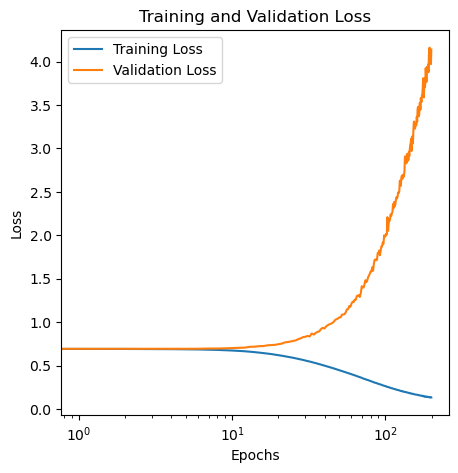

In [37]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Loss')
plt.legend()
plt.show()

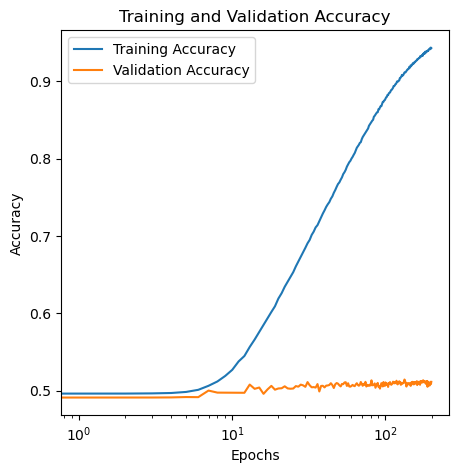

In [38]:
plt.figure(figsize=(5, 5))
plt.plot(history_dict['binary_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
loss, accuracy = model.evaluate(test_x, test_y)
print('Loss:', loss)
print('Accuracy:', accuracy)

511/511 [==============================] - 0s 596us/step - loss: 4.1775 - binary_accuracy: 0.5030
Loss: 4.177544593811035
Accuracy: 0.5029672980308533


In [27]:
data = tf.random.uniform([1024, 4])
ds = tf.data.Dataset.from_tensor_slices(data)
ds = ds.batch(32)
ds1 = ds.take(16)
ds2 = ds.skip(16).take(16)

In [ ]:
data = tf.random.uniform([1024, 4])
ds = tf.data.Dataset.from_tensor_slices(data)
ds1 = ds.take(512).batch(32)
ds2 = ds.skip(512).take(512).batch(32)

In [47]:
# Save the model
export_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Activation('sigmoid')
])

In [59]:
game = 'Aatrox,Nidalee,Velkoz,Jhin,Nautilus,Darius,Nocturne,Zoe,Draven,Shaco,true'
vec = process_match(game)[:-1]
out = export_model.predict([vec])
if out > 0.5:
    print('Win')
else:
    print('Loss')

1/1 [==============================] - 0s 18ms/step
Win


In [36]:
tfjs.converters.save_keras_model(export_model, 'winpredictor/public/models/master')